In [1]:
import pandas as pd
import numpy as np
import os
import ast
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Get avg for runs and then write all paras & data into a Dataframe

In [3]:
# func to get avgs for runs
def get_simulation_averages_with_titles(df):
    def safe_literal_eval(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return np.nan

    def calculate_average_list(column):
        return column.apply(safe_literal_eval).apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

    averages_df = pd.DataFrame()

    for column in df.columns[1:]:
        avg = calculate_average_list(df[column])
        averages_df[column] = avg

    return averages_df

In [5]:
pattern = './200_2000_*.csv'
all_results = pd.DataFrame()

for filepath in glob.glob(pattern):
    temp_df = pd.DataFrame()
    df = pd.read_csv(filepath)
    average = get_simulation_averages_with_titles(df)
    
    averages = average.mean()

    averages_df = pd.DataFrame([averages])
    averages_df['Default Prob'] = averages_df['Number of Bankrupt Agents Over Time'] / averages_df['Node Population Over Time']

    filename = os.path.basename(filepath).replace('.csv', '')
    parts = filename.split('_')
    N_agents = int(parts[0])
    num_steps = int(parts[1])
    delta_t = float(parts[2])
    sigma_exposure_node = float(parts[3])
    sigma_intrestrate = float(parts[4])
    threshold_v = float(parts[5])
    linking_threshold = float(parts[6])

    para_df = pd.DataFrame({
        'N_agents': [N_agents],
        'num_steps': [num_steps],
        'delta_t': [delta_t],
        'sigma_exposure_node': [sigma_exposure_node],
        'sigma_intrestrate': [sigma_intrestrate],
        'threshold_v': [threshold_v],
        'linking_threshold': [linking_threshold]
    })

    temp_df = pd.concat([averages_df, para_df], axis=1)

    all_results = pd.concat([all_results, temp_df], ignore_index=True)

#### Default Prob vs. Total Link Exposure without std.

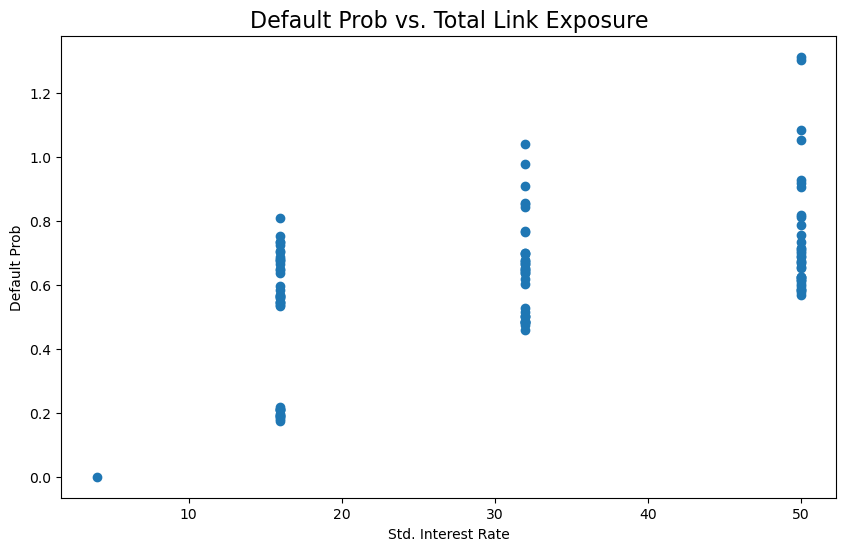

In [18]:
plt.figure(figsize=(10, 6))

plt.scatter(all_results['sigma_intrestrate'], all_results['Default Prob'])
plt.xlabel('Std. Interest Rate')
plt.ylabel('Default Prob')
plt.title('Default Prob vs. Total Link Exposure', fontsize=16)

plt.show()

#### 3D plot Default Prob vs. Link Exposure vs. Std. Interest Rate

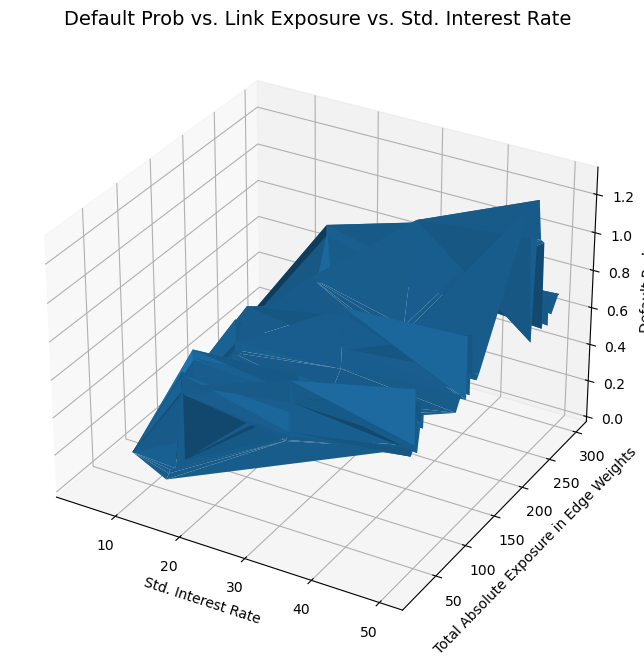

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(all_results['sigma_intrestrate'], all_results['Total Absolute Exposure in Edge Weights'], all_results['Default Prob'])

ax.set_xlabel('Std. Interest Rate')
ax.set_ylabel('Total Absolute Exposure in Edge Weights')
ax.set_zlabel('Default Prob')
ax.set_title('Default Prob vs. Link Exposure vs. Std. Interest Rate', fontdict={'fontsize': 14})

plt.show()

### Plot with std version

In [2]:
def get_statistics(pattern : str = './200_2000_*.csv'):

    '''
    To get statistics of 
    '''

    def safe_literal_eval(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return np.nan

    def calculate_average_list(column):
        return column.apply(safe_literal_eval).apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

    def calculate_std_list(column):
        return column.apply(safe_literal_eval).apply(lambda x: np.std(x) if isinstance(x, list) and len(x) > 0 else np.nan)
    
    def calculate_elementwise_division(a, b):
        return [i/j for i, j in zip(a, b)]


    all_results = pd.DataFrame()
    all_stds = pd.DataFrame()

    for filepath in glob.glob(pattern):
        df = pd.read_csv(filepath)

        df['Default Prob'] = df.apply(
        lambda row: calculate_elementwise_division(
            safe_literal_eval(row['Number of Bankrupt Agents Over Time']),
            safe_literal_eval(row['Node Population Over Time'])
        ), axis=1)

        # print(df['Default Prob'])
    
        averages_df = pd.DataFrame()
        stds_df = pd.DataFrame()

        for column in df.columns[1:-1]:
            avg = calculate_average_list(df[column])
            std = calculate_std_list(df[column])
            averages_df[column] = avg
            stds_df[column] = std

        
        averages_df['Default Prob'] = df['Default Prob'].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)
        stds_df['Default Prob'] = df['Default Prob'].apply(lambda x: np.std(x) if isinstance(x, list) and len(x) > 0 else np.nan)
        
        averages = averages_df.mean()
        stds = stds_df.mean()

        averages_df_overall = pd.DataFrame([averages])
        stds_df_overall = pd.DataFrame([stds])

        filename = os.path.basename(filepath).replace('.csv', '')
        parts = filename.split('_')
        N_agents = int(parts[0])
        num_steps = int(parts[1])
        delta_t = float(parts[2])
        sigma_exposure_node = float(parts[3])
        sigma_intrestrate = float(parts[4])
        threshold_v = float(parts[5])
        linking_threshold = float(parts[6])

        para_df = pd.DataFrame({
        'N_agents': [N_agents],
        'num_steps': [num_steps],
        'delta_t': [delta_t],
        'sigma_exposure_node': [sigma_exposure_node],
        'sigma_intrestrate': [sigma_intrestrate],
        'threshold_v': [threshold_v],
        'linking_threshold': [linking_threshold]
    })

        temp_df = pd.concat([averages_df_overall, para_df], axis=1)

        all_results = pd.concat([all_results, temp_df], ignore_index=True)
        all_stds = pd.concat([all_stds, stds_df_overall], ignore_index=True)

    return all_results, all_stds

In [5]:
pattern = './200_2000_*.csv'

all_results, all_stds = get_statistics(pattern = pattern)

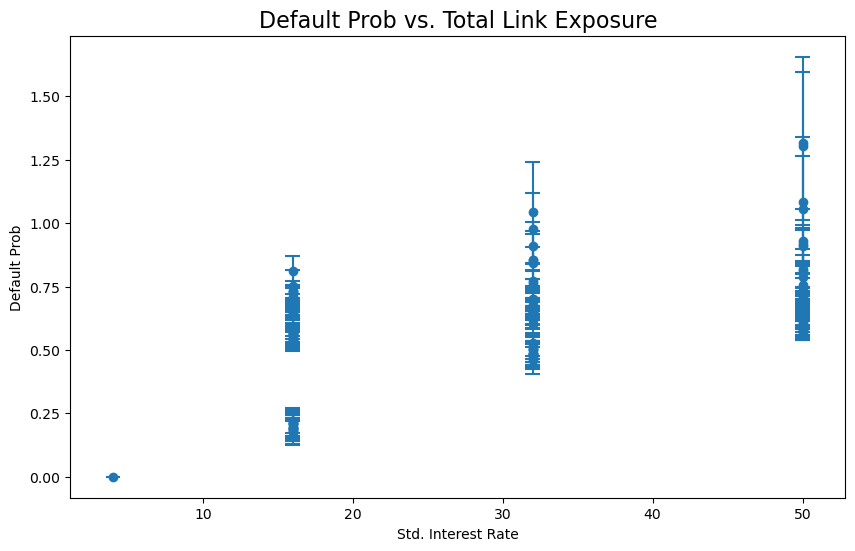

In [6]:
plt.figure(figsize=(10, 6))

plt.scatter(all_results['sigma_intrestrate'], all_results['Default Prob'])

for x, y, yerr in zip(all_results['sigma_intrestrate'], all_results['Default Prob'], all_stds['Default Prob']):
    plt.vlines(x, y - yerr, y + yerr)
    plt.hlines(y - yerr, x - 0.5, x + 0.5)
    plt.hlines(y + yerr, x - 0.5, x + 0.5)

plt.xlabel('Std. Interest Rate')
plt.ylabel('Default Prob')
plt.title('Default Prob vs. Total Link Exposure', fontsize=16)

plt.show()

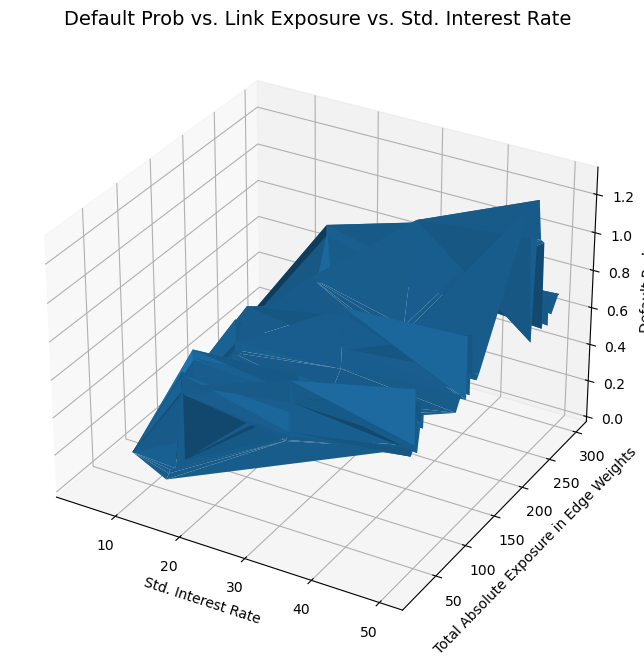

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(all_results['sigma_intrestrate'], all_results['Total Absolute Exposure in Edge Weights'], all_results['Default Prob'])

ax.set_xlabel('Std. Interest Rate')
ax.set_ylabel('Total Absolute Exposure in Edge Weights')
ax.set_zlabel('Default Prob')
ax.set_title('Default Prob vs. Link Exposure vs. Std. Interest Rate', fontdict={'fontsize': 14})

plt.show()

### Set Plot functions

In [7]:
def plot_simu_2D_results(pattern : str = './200_2000_*.csv', x_axis_name : str = 'sigma_intrestrate',
y_axis_name : str = 'Default Prob'):
    
    all_results, all_stds = get_statistics(pattern = pattern)
    plt.figure(figsize=(10, 6))

    plt.scatter(all_results[x_axis_name], all_results[y_axis_name])

    for x, y, yerr in zip(all_results[x_axis_name], all_results[y_axis_name], all_stds[y_axis_name]):
        plt.vlines(x, y - yerr, y + yerr)
        plt.hlines(y - yerr, x - 0.5, x + 0.5)
        plt.hlines(y + yerr, x - 0.5, x + 0.5)

    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(f'{x_axis_name} vs. {y_axis_name}', fontsize=16)

    plt.show()

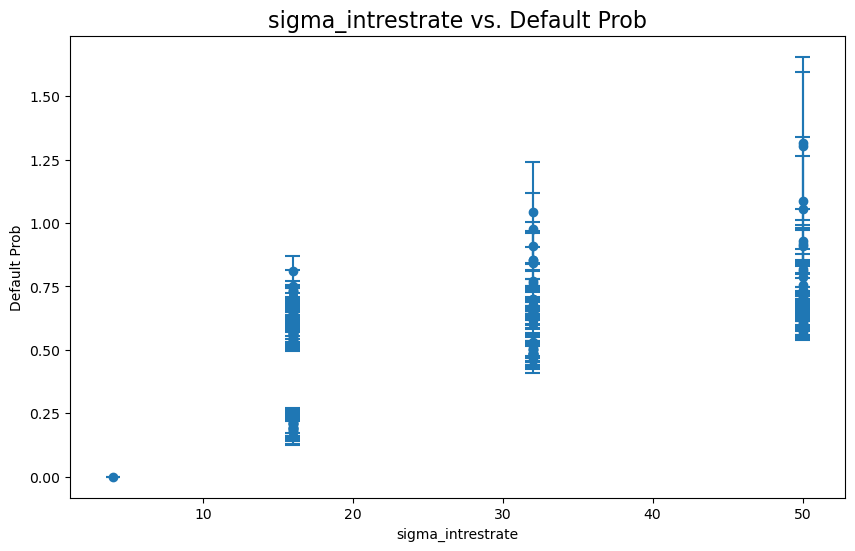

In [8]:
plot_simu_2D_results()

In [6]:
def plot_simu_3D_results(pattern : str = './200_2000_*.csv', x_axis_name : str = 'sigma_intrestrate',
y_axis_name : str = 'Total Absolute Exposure in Edge Weights', z_axis_name : str = 'Default Prob'):
    
    all_results, _ = get_statistics(pattern = pattern)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(all_results[x_axis_name], all_results[y_axis_name], all_results[z_axis_name])

    ax.set_xlabel(x_axis_name)
    ax.set_ylabel(y_axis_name)
    ax.set_zlabel(z_axis_name)
    ax.set_title(f'{x_axis_name} vs.{y_axis_name} vs. {z_axis_name}', fontdict={'fontsize': 14})

    plt.show()


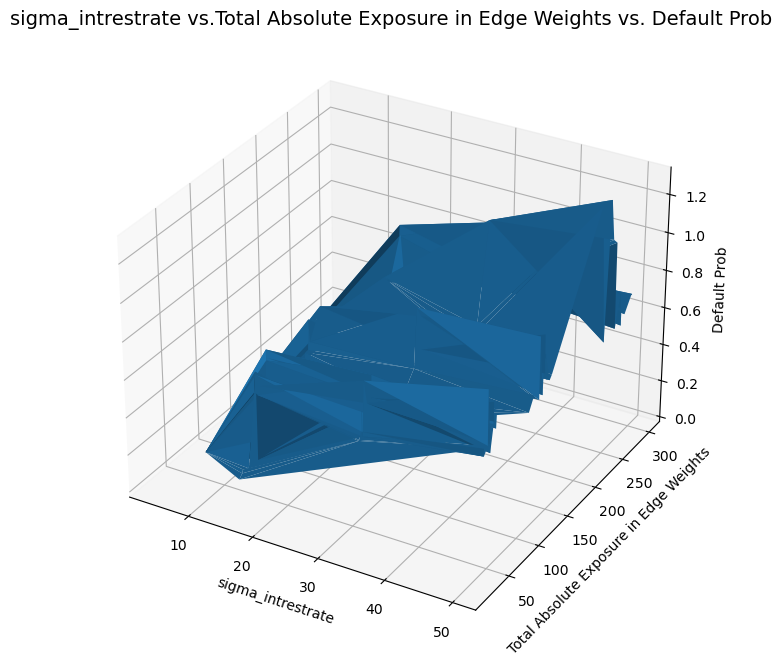

In [7]:
plot_simu_3D_results()